In [192]:
# For Kmeans algorithm. See PGM otherwise for handcrafted class
from sklearn.cluster import KMeans
# For loading matlab matrix file
from scipy.io import loadmat
# Hungarian algorithm
from scipy.optimize import linear_sum_assignment

#from scipy.sparse.linalg import eigs, eigsh
from scipy.stats import itemfreq
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

# Globals

In [3]:
DATA_DIR = "data/"

# Data

In [280]:
YaleB = loadmat(DATA_DIR + 'ExtendedYaleB.mat')
data = YaleB['EYALEB_DATA'].astype(np.int64)
ground_truth = YaleB['EYALEB_LABEL'].reshape(-1) - 1

## Construct data sets of individuals

In [281]:
keys = [2, 10, 20, 30, 38]
data_set = {key : {"data" : data[:, ground_truth < key],
                   "labels" : ground_truth[:(ground_truth < key).sum()]
                  } for key in keys}

In [277]:
data_set

{2: {'data': array([[ 83,  94,  78, ...,   5,   5,   6],
         [ 84,  93,  88, ...,   5,   4,   6],
         [ 84,  93,  99, ...,   3,   3,   4],
         ..., 
         [ 34,  15,   8, ..., 218,  67,  15],
         [ 27,  12,   7, ..., 222,  79,  16],
         [ 15,   8,   5, ..., 228,  92,  18]]),
  'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)},
 10: {'data': array([[ 83,  94,  78, ...,   9,   8,  10],
         [ 84,  93,  88, ...,   8,   8,  10],
         [ 84,  93,  99, ...,   8,   8,  10],
         ..., 
         [ 34,  15,   8, ..., 106, 128, 113],
         [ 27,  12,  

# Functions

In [94]:
def minWeightBipartiteMatching(clusteringA, clusteringB):
    """
    labels from cluster A will be matched on the labels from cluster B
    source : https://www.r-bloggers.com/matching-clustering-solutions-using-the-hungarian-method/
    """
    # Reshape to have column vectors
    clusteringA = clusteringA.reshape(-1)
    clusteringB = clusteringB.reshape(-1)
    
    # Distinct cluster ids in A and B
    idsA, idsB = np.unique(clusteringA), np.unique(clusteringB)
    # Number of instances in A and B
    nA, nB = len(clusteringA), len(clusteringB)
    
    if len(idsA) != len(idsB):
        raise ValueError("Dimensions of clustering do no match")
    if  nA != nB:
        raise ValueError("Lengths of clustering do no match")

    nC = len(idsA)
    tupel = np.arange(nA)

    # Computing the distance matrix
    assignmentMatrix = -1 + np.zeros((nC, nC))
    for i in range(nC):
        tupelClusterI = tupel[clusteringA == i]
        for j in range(nC):
            nA_I = len(tupelClusterI)
            tupelB_I = tupel[clusteringB == j]
            nB_I = len(tupelB_I)
            nTupelIntersect = len(np.intersect1d(tupelClusterI, tupelB_I))
            assignmentMatrix[i, j] = (nA_I - nTupelIntersect) + (nB_I - nTupelIntersect)

    # Optimization
    _, result = linear_sum_assignment(assignmentMatrix)
    return result

In [119]:
def minWeightBipartiteMatching_2(clusteringA, clusteringB):
    """
    labels from cluster A will be matched on the labels from cluster B
    source : https://www.r-bloggers.com/matching-clustering-solutions-using-the-hungarian-method/
    """
    # Reshape to have column vectors
    clusteringA = clusteringA.reshape(-1)
    clusteringB = clusteringB.reshape(-1)
    
    # Distinct cluster ids in A and B
    idsA, idsB = np.unique(clusteringA), np.unique(clusteringB)
    # Number of instances in A and B
    nA, nB = len(clusteringA), len(clusteringB)
    
    if  nA != nB:
        raise ValueError("Lengths of clustering do no match")

    nC = max(len(idsA), len(idsB))
    tupel = np.arange(nA)

    # Computing the distance matrix
    assignmentMatrix = -1 + np.zeros((nC, nC))
    for i in range(nC):
        tupelClusterI = tupel[clusteringA == i]
        for j in range(nC):
            nA_I = len(tupelClusterI)
            tupelB_I = tupel[clusteringB == j]
            nB_I = len(tupelB_I)
            nTupelIntersect = len(np.intersect1d(tupelClusterI, tupelB_I))
            assignmentMatrix[i, j] = (nA_I - nTupelIntersect) + (nB_I - nTupelIntersect)

    # Optimization
    _, result = linear_sum_assignment(assignmentMatrix)
    return result

In [263]:
def evaluate_error(predictions, ground_truth, verbose = True):
    """
    Evaluate error for all possible permuatations of n letters
    -----------------------------------------------------------------------------------
    Parameters :
    ------------
    predictions : list of size K1
                  labels predicted from a clustering algorithm
    ground_truth : list of size K2
                   true labels
    
    Returns :
    ---------
    error : integer
    
    
    Sources :
    # 4.3.1
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.101.2605&rep=rep1&type=pdf
    # Other possible source
    https://www.r-bloggers.com/matching-clustering-solutions-using-the-hungarian-method/
    ------------------------------------------------------------------------------------
    """
    ## WARNING : only works if labels in range(d1), d1 positive integer
    # Construct the Hungarian matrix and get the mapping dictionnary
    dic = minWeightBipartiteMatching_2(predictions, ground_truth)
    
    # Translate predictions in term of ground_truth labels
    mapped_pred = predictions.copy()
    for k,i in enumerate(dic):
        mapped_pred[predictions == k] = i

    # Compute error
    error = (mapped_pred != ground_truth).sum() / len(ground_truth)
    
    # To do : plot confusion matrix
    
    if verbose:
        print ("Erreur : {}".format(error))
    return error

In [6]:
def gaussian_affinity(X, k, sigma, distance_matrix = None):
    """
    Construction of gaussian affinity with K-NN :
    w_{ij} = exp(-d_{ij}^2 / 2s^2) if NN 0 else
    
    Parameters :
    ------------
    X: array, shape [NxD]
       N data points
    k: positive integer
       number of nearest neighbors to consider
    sigma: positive integer
       standard deviation of the gaussian kernel
    
    Returns :
    ---------
    W: array, shape [NxN]
       affinity matrix
    
    """
    if distance_matrix is None:
#         # Care not to swap with this faster method (minimum RAM for YaleB : 32Gb)
#         A = np.tile(X, (X.shape[1], 1, 1)) - X.T.reshape(X.shape[1], -1, 1)
#         D = np.linalg.norm(A, axis = 1)

        # Awful method
        distance_matrix = np.array([np.linalg.norm(X - x.reshape(-1, 1), axis = 0)\
                                    for x in X.T])

        # No idea why D is not symetric, but same trick in scitkitlearn
        distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)


    np.fill_diagonal(distance_matrix, np.inf)
    W = np.inf * np.ones(distance_matrix.shape)
    # Matrix of rank of nearest neighbors
    KNN = distance_matrix.argsort()[:, :k]
    for k,i in enumerate(KNN):
        if np.isin(k, KNN[i]):
            W[k, i] = distance_matrix[k, i]
    
    W = (W + W.T)/2

    return np.exp(-0.5 * (W / sigma) **2)

In [190]:
def SC(W, n, method = "full"):
    """
    Spectral Clustering algorithm.
    :param W: affinity matrix NxN (N : number of points)
    :param n: number of clusters
    :return : Segmentation of the data in n groups
    """
    # 1. Construct an affinity graph G with weight matrix W
    # 2. Compute the degree matrix D = diag(W1) and the Laplacian L = D - W
    D = np.diag(W.sum(axis = 1))
    L = D - W
    # 3. Compute the n eigenvectors of L associated with its n smallest eigenvalues
    ## May use scipy.sparse.linalg.eigs to speed up computation
    ## The vectors returned by linalg are normalized
    if method == "sparse":
        # SC(W, 10, method = "sparse")
        # 2 s ± 87.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        ## !!! Not functionning because not returning THE smallest ones
        evalues, evectors = eigsh(L, k=n, which = 'SM')
    else :
        # SC(W, 10, method = "full")
        # 37.5 s ± 2.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
        evalues, evectors = np.linalg.eigh(L)
    # 4. Y : transpose of matrix of eigenvectors normalized by euclidien norm
    ## Y.shape = (N x n).T => n x N
    Y = evectors[:, :n].T
    # 5. Cluster the points {y_j}_1^N into n groups using the K-means algorithm
    ## n_jobs controls the number of threads
    ## init with random as in algorithm 4.4
    kmeans = KMeans(n_clusters = n, n_jobs = -1, init = 'random').fit(Y.T)
    # Return the label for each point : not the exact segmentation as in algo 4.4
    return kmeans.labels_

# Test zone

In [191]:
data.shape

(2016, 2414)

In [13]:
# Distance matrix
# distance_matrix = np.array([np.linalg.norm(data - x.reshape(-1, 1), axis = 0) for x in data.T])
# distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)

In [195]:
W = gaussian_affinity(data, 11, 10e3, distance_matrix = distance_matrix)
print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
W

Percentage of W filled : 0.04832347072345864%


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


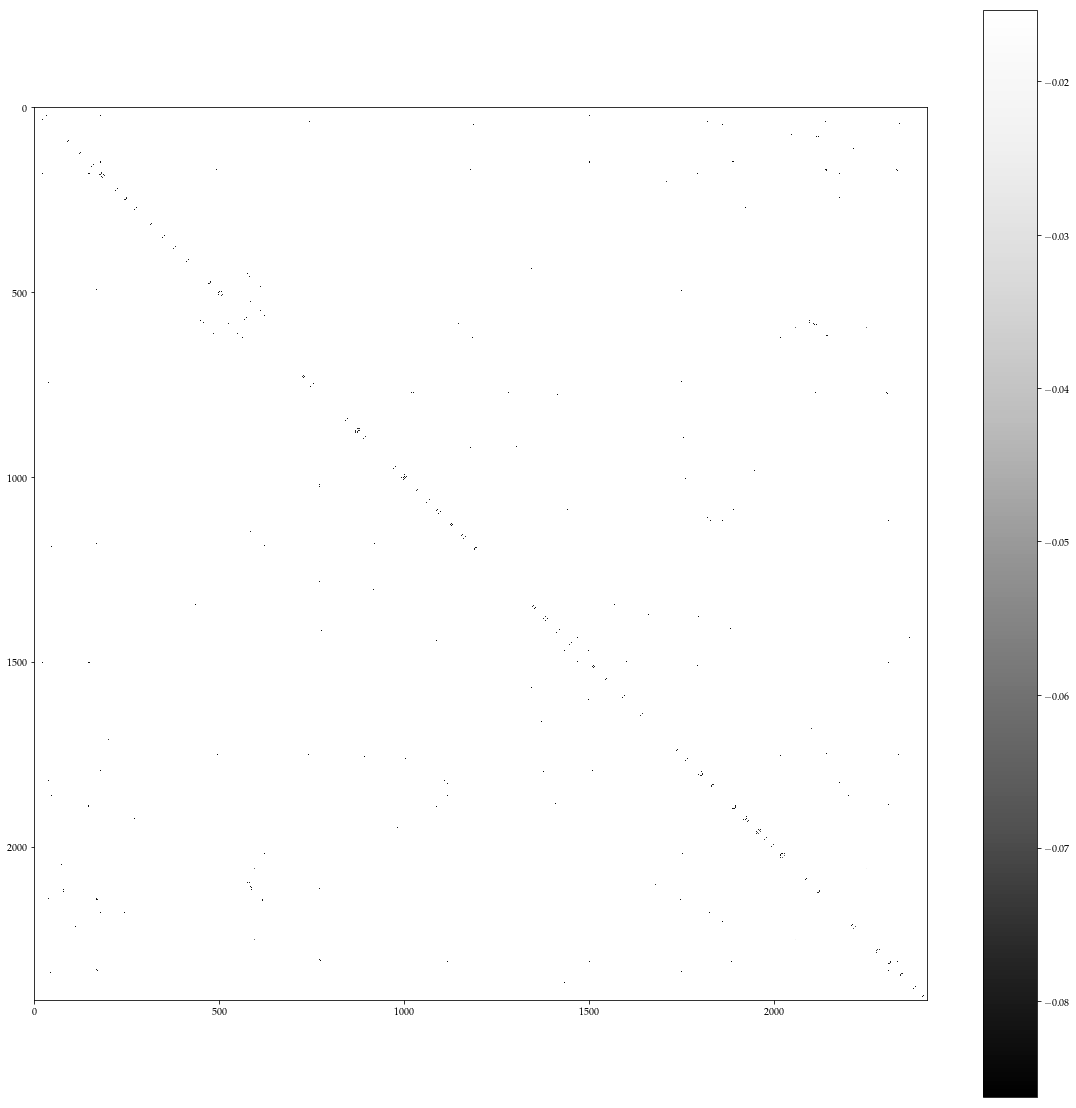

In [197]:
plt.figure(figsize= (20, 20))
plt.imshow(np.log10(W), cmap = "Greys_r");
plt.colorbar();

In [198]:
% timeit res = SC(W, 38)
res

3.18 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([ 6, 27, 30, ...,  4, 26, 33], dtype=int32)

In [199]:
evaluate_error(res, ground_truth)

Erreur : 0.9254349627174814


0.92543

# Scikit-learn algorithms

In [26]:
from sklearn.cluster import SpectralClustering

In [40]:
SC = SpectralClustering(n_clusters = 38, n_jobs = -1 ).fit(data.T)
itemfreq(SC.labels_)

/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([[   0,   16],
       [   1,    1],
       [   2,    1],
       [   3,    1],
       [   4,  129],
       [   5,    2],
       [   6,    1],
       [   7,    1],
       [   8,   77],
       [   9,    1],
       [  10,    1],
       [  11,    2],
       [  12,    2],
       [  13,    1],
       [  14,    1],
       [  15,    1],
       [  16,    1],
       [  17,    1],
       [  18,    2],
       [  19,    1],
       [  20, 2088],
       [  21,    1],
       [  22,    3],
       [  23,    2],
       [  24,    4],
       [  25,    1],
       [  26,    1],
       [  27,    5],
       [  28,    9],
       [  29,    1],
       [  30,    1],
       [  31,    1],
       [  32,   18],
       [  33,    1],
       [  34,   32],
       [  35,    1],
       [  36,    1],
       [  37,    1]])

# Not the smallest evectors taken

In [186]:
G = np.random.rand(10, 10)
G = 0.5 * (G + G.T)

In [125]:
eval1, evec1 = eigs(G, k = 5)

In [128]:
eval1.astype(float)

/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([ 4.58350447, -1.16432174,  0.82995751, -0.86105969, -0.63981727])

In [187]:
%timeit eval2, evec2= np.linalg.eig(G)
eval2

62.5 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([-1.16432174, -0.86105969, -0.63981727, -0.40648039, -0.27145041,
        0.18287562,  0.27200556,  0.34746985,  0.82995751,  4.58350447])

In [188]:
%timeit eval2, evec2= np.linalg.eigh(G)
eval2

43.1 µs ± 652 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([-1.16432174, -0.86105969, -0.63981727, -0.40648039, -0.27145041,
        0.18287562,  0.27200556,  0.34746985,  0.82995751,  4.58350447])

In [189]:
%timeit eval1, evec1 = eigsh(G, k = 5, which = 'SM')
eval1

334 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([-1.16432174, -0.86105969, -0.63981727,  0.82995751,  4.58350447])

# Error evalutation

In [42]:
np.unique(ground_truth)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=uint8)

In [92]:
# Test
cA, cB = np.array([1, 1, 2, 3, 3, 4, 4, 4, 2]) - 1, np.array([2, 2, 3, 1, 1, 4, 4, 4, 3]) - 1

In [153]:
print ("cA : ", cA)
print ("cB : ", cB)

cA :  [0 0 1 2 2 3 3 3 1]
cB :  [1 1 2 0 0 3 3 3 2]


In [157]:
R = minWeightBipartiteMatching(cA, cB)
for k,i in enumerate(R):
    print (k, i)

0 1
1 2
2 0
3 3


In [158]:
# Translate cA to cB
A = cA.copy()
for k,i in enumerate(R):
    A[cA == k] = i
A

array([1, 1, 2, 0, 0, 3, 3, 3, 2])

In [97]:
minWeightBipartiteMatching(res, ground_truth)

array([22, 33,  3,  1, 25, 36, 28, 13, 17,  2, 35, 24, 16, 18, 11, 12, 34,
       26, 21, 19,  8, 10, 32, 29,  7, 15,  9,  4, 31,  6, 20,  5, 27, 14,
       37, 23, 30,  0])

In [98]:
minWeightBipartiteMatching(ground_truth, res)

array([37,  3,  9,  2, 27, 31, 14, 24, 20, 26, 21, 11, 15, 29, 33, 25, 12,
        8, 13, 17, 30, 18,  0, 35,  7,  4, 19, 32,  6, 23, 36, 28, 22,  1,
       16, 10,  5, 34])

## Test of version 2 with not same "dimension"

In [108]:
cB

array([1, 1, 2, 0, 0, 3, 3, 3, 2])

In [107]:
cA2 = np.array([1, 1, 2, 3, 3, 4, 6, 6, 2]) - 1
cA2

array([0, 0, 1, 2, 2, 3, 5, 5, 1])

In [118]:
minWeightBipartiteMatching_2(cA2, cB)

(array([1, 2, 0, 3, 4]), array([[ 4.,  0.,  4.,  5.,  2.],
        [ 4.,  4.,  0.,  5.,  2.],
        [ 0.,  4.,  4.,  5.,  2.],
        [ 3.,  3.,  3.,  2.,  1.],
        [ 2.,  2.,  2.,  3.,  0.]]))

## Error evaluation

###  WIth same number of clusters in ground_truth and in res

In [168]:
SC = SpectralClustering(n_clusters = 38, n_jobs = -1 ).fit(data.T)
# SC.labels_

/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [173]:
# With same number of clusters
evaluate_error(SC.labels_, ground_truth)

0.95692

### with different number of clusters, no matter what is the signification

In [174]:
SC_2 = SpectralClustering(n_clusters = 10, n_jobs = -1 ).fit(data.T)
# SC.labels_

/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [179]:
# With same number of clusters
evaluate_error(SC_2.labels_, ground_truth)

Erreur : 0.9643744821872411


0.96437

# Optimization of parameters

In [251]:
# Keys of data_set, ascent order
I = np.array(list(data_set.keys()))
I.sort()
I

array([ 2, 10, 20, 30, 38])

In [252]:
#Length of dataset
length = {}
print ("---- Length of datasets : ----")
for i in I:
    length[i] = len(data_set[i]["labels"])
    print ("For individuals 1-{} : {}". format(i, len(data_set[i]["labels"])))

---- Length of datasets : ----
For individuals 1-2 : 128
For individuals 1-10 : 640
For individuals 1-20 : 1262
For individuals 1-30 : 1902
For individuals 1-38 : 2414


In [260]:
SC_res = {i: {} for i in I}
SC_res

{2: {}, 10: {}, 20: {}, 30: {}, 38: {}}

## Individuals 1-2

In [255]:
# Individual parameter
i = 2
# KNN parameter
k = 3
# Gaussian sigma
s = 10e2


W = gaussian_affinity(data_set[i]["data"], k, s)
print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
res = SC(W, i)
_ = evaluate_error(res, data_set[i]["labels"])

Percentage of W filled : 0.54931640625%
Erreur : 0.4453125


In [268]:
# for k in np.arange(1, length[i], 2):
for k in np.arange(1, length[i], 10):
    SC_res[i][k] = {}
    for s in 10**np.arange(3):
        SC_res[i][k][s] = {}
        W = gaussian_affinity(data_set[i]["data"], k, s)
#         print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
        SC_res[i][k][s]["W_filled"] = (W > 0).sum() / len(W)**2 * 100
        SC_res[i][k][s]["labels"] = SC(W, i)
        SC_res[i][k][s]["error"] = evaluate_error(SC_res[i][k][s]["labels"],
                                            data_set[i]["labels"], verbose = False)


In [269]:
SC_res

{2: {1: {1: {'W_filled': 0.00000,
    'error': 0.49219,
    'labels': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)},
   10: {'W_filled': 0.00000,
    'error': 0.49219,
    'labels': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

### After casting uint8 (matlab format) in int64 (8 bytes)

In [284]:
# for k in np.arange(1, length[i], 2):
for k in np.arange(1, length[i], 10):
    SC_res[i][k] = {}
    for s in 10**np.arange(3):
        SC_res[i][k][s] = {}
        W = gaussian_affinity(data_set[i]["data"], k, s)
#         print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
        SC_res[i][k][s]["W_filled"] = (W > 0).sum() / len(W)**2 * 100
        SC_res[i][k][s]["labels"] = SC(W, i)
        SC_res[i][k][s]["error"] = evaluate_error(SC_res[i][k][s]["labels"],
                                            data_set[i]["labels"], verbose = False)


# Individuals 1-10

In [288]:
# Individual parameter
i = 10
# KNN parameter
k = 3
# Gaussian sigma
s = 10e2


W = gaussian_affinity(data_set[i]["data"], k, s)
print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
res = SC(W, i)
_ = evaluate_error(res, data_set[i]["labels"])

Percentage of W filled : 0.30078125%
Erreur : 0.7046875


In [293]:
A = np.arange(9).reshape(3,3)
A = A + A.T
A

array([[ 0,  4,  8],
       [ 4,  8, 12],
       [ 8, 12, 16]])

In [295]:
qq1, qq2 = np.linalg.eigh(A)